In [23]:
import os
import pandas as pd
import numpy as np
import scipy as sts
import matplotlib.pyplot as plt
import gmaps
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime

In [26]:
world_df= pd.read_csv("../Resources/owid-covid-data.csv")


updated_world_df=world_df.drop(["iso_code", "new_deaths_per_million","total_tests","new_tests",
                                "new_tests_smoothed_per_thousand","population","median_age","aged_70_older",
                                "extreme_poverty","diabetes_prevalence","female_smokers","male_smokers",
                               "handwashing_facilities","hospital_beds_per_thousand","life_expectancy",
                               "new_tests_smoothed","new_tests_per_thousand","tests_units","total_deaths",
                               "new_deaths","total_cases_per_million","new_cases_per_million"], axis=1)

updated_world_df=updated_world_dfupdated_world_df=updated_world_df.rename(columns={"location":"Country", "continent":"Continent","date":"Date",
                                                  "total_deaths_per_million":"Total Deaths Per Million","total_cases":"Total Cases", "new_cases":"New Cases",
                                                  "total_tests_per_thousand":"Total Test Per Thousands",
                                                 "population_density":"Population Density","aged_65_older":"Aged 65 or older",
                                                 "gdp_per_capita":"GDP Per Capita","cvd_death_rate":"Covid Death Rate",
                                                 "stringency_index":"Stringency Index"})

#updated_world_df.fillna(0, inplace=True)

updated_world_df.head()

,Continent,Country,Date,Total Cases,New Cases,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate
0,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,NaN,NaN,54.422,2.581,1803.987,597.029
1,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029
2,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029
3,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029
4,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029


In [11]:
#Number Hospital Beds is based on the lastest year per Country

data = pd.read_csv("../Resources/data.csv")

who_df = data.iloc[data.groupby("Country")["Year"].agg(pd.Series.idxmax)]
who_df.reset_index(drop=True).set_index("Country")
who_df=who_df.rename(columns={"Hospital beds (per 10 000 population)":"Hospital Beds (per 10K people)"})
hospital_beds_df=who_df.drop(["Year"], axis=1)

hospital_beds_df.head()

,Country,Hospital Beds (per 10K people)
0,Afghanistan,5
16,Albania,29
29,Algeria,19
31,Angola,8
32,Antigua and Barbuda,38


In [12]:
#Smoking Percentage is based on the lastest year per Country

smokingdata = pd.read_csv("../Resources/smokingdata.csv")

smokingdata_df = smokingdata.iloc[smokingdata.groupby("Country")["Year"].agg(pd.Series.idxmax)]

clean_smoking_data = smokingdata_df.drop(["Estimate of current cigarette smoking prevalence (%).1", "Estimate of current cigarette smoking prevalence (%).2", 
                                       "Estimate of current tobacco smoking prevalence (%)", "Estimate of current tobacco smoking prevalence (%).1", 
                                       "Estimate of current tobacco smoking prevalence (%).2", "Estimate of current tobacco use prevalence (%)", 
                                       "Estimate of current tobacco use prevalence (%).1", "Estimate of current tobacco use prevalence (%).2"], axis=1)

 
clean_smoking_data=clean_smoking_data.rename(columns={"Estimate of current cigarette smoking prevalence (%)":"Smoking Prevalence (%)"})
smoking_data = clean_smoking_data
smoking_prevalence=list(smoking_data["Smoking Prevalence (%)"])
smoking_percentage=[]

for x in smoking_prevalence:
    y=x.split("[")
    smoking_percentage.append(y[0])
    

    
column_values = pd.Series(smoking_percentage)
smoking_data.insert(loc=2, column="Smoking Percetage", value=column_values)
smoking_year_df=smoking_data.drop(["Smoking Prevalence (%)"], axis=1)

smoking_df=smoking_year_df.drop(["Year"], axis=1)

smoking_df.head()

,Country,Smoking Percetage
1,Albania,11.20
7,Algeria,15.20
13,Andorra,21.40
19,Argentina,31.40
25,Armenia,6.00


In [13]:
world_df=pd.read_csv("../Resources/dsh_simple.csv")

world_df=world_df[["Countryname","IfclosedduetoCOVID19whend","Statusof Schoolsaresomeall (copy) (group)",
          "Latitude (generated)","Longitude (generated)","Incomelevelname"]]

income_level_df=world_df.rename(columns={"Countryname":"Country", "Latitude (generated)":"Latitude", 
                      "Longitude (generated)": "Longitude", "Incomelevelname": "Income Level",
                        "Statusof Schoolsaresomeall (copy) (group)":"School Status"})
income_df=income_level_df.drop(["IfclosedduetoCOVID19whend"], axis =1)

income_df.head()

,Country,School Status,Latitude,Longitude,Income Level
0,Eritrea,Closed,15.9820,38.0200,Low income
1,Guinea-Bissau,Closed,12.1910,-14.4750,Low income
2,San Marino,Closed,43.9420,12.4611,High income
3,Georgia,Closed,42.0500,43.5760,Upper middle income
4,Italy,Closed,44.3713,11.1084,High income


In [14]:
combined_df=pd.merge(updated_world_df,hospital_beds_df,on="Country",how="left").merge(smoking_df,on="Country",how="left" ).merge(income_df,on="Country",how="left")

combined_df.head(200)

,Continent,Country,Date,Total Cases,New Cases,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,Hospital Beds (per 10K people),Smoking Percetage,School Status,Latitude,Longitude,Income Level
0,Asia,Afghanistan,2019-12-31,0.0,0.0,0.000,NaN,NaN,54.422,2.581,1803.987,597.029,5.0,NaN,Closed,34.023,65.5267,Low income
1,Asia,Afghanistan,2020-01-01,0.0,0.0,0.000,NaN,0.00,54.422,2.581,1803.987,597.029,5.0,NaN,Closed,34.023,65.5267,Low income
2,Asia,Afghanistan,2020-01-02,0.0,0.0,0.000,NaN,0.00,54.422,2.581,1803.987,597.029,5.0,NaN,Closed,34.023,65.5267,Low income
3,Asia,Afghanistan,2020-01-03,0.0,0.0,0.000,NaN,0.00,54.422,2.581,1803.987,597.029,5.0,NaN,Closed,34.023,65.5267,Low income
4,Asia,Afghanistan,2020-01-04,0.0,0.0,0.000,NaN,0.00,54.422,2.581,1803.987,597.029,5.0,NaN,Closed,34.023,65.5267,Low income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Europe,Albania,2020-04-08,383.0,6.0,7.645,NaN,84.26,104.871,13.188,11803.431,304.195,29.0,11.20,Open with limitations,40.654,20.0760,Upper middle income
196,Europe,Albania,2020-04-09,400.0,17.0,7.645,NaN,84.26,104.871,13.188,11803.431,304.195,29.0,11.20,Open with limitations,40.654,20.0760,Upper middle income
197,Europe,Albania,2020-04-10,409.0,9.0,7.992,NaN,84.26,104.871,13.188,11803.431,304.195,29.0,11.20,Open with limitations,40.654,20.0760,Upper middle income
198,Europe,Albania,2020-04-11,416.0,7.0,7.992,NaN,84.26,104.871,13.188,11803.431,304.195,29.0,11.20,Open with limitations,40.654,20.0760,Upper middle income


In [15]:
world_data = combined_df[combined_df['Country']=='World']
world_data

,Continent,Country,Date,Total Cases,New Cases,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,Hospital Beds (per 10K people),Smoking Percetage,School Status,Latitude,Longitude,Income Level
25258,NaN,World,2019-12-31,27.0,27.0,0.000,NaN,NaN,58.045,8.696,15469.207,233.07,NaN,NaN,NaN,NaN,NaN,NaN
25259,NaN,World,2020-01-01,27.0,0.0,0.000,NaN,NaN,58.045,8.696,15469.207,233.07,NaN,NaN,NaN,NaN,NaN,NaN
25260,NaN,World,2020-01-02,27.0,0.0,0.000,NaN,NaN,58.045,8.696,15469.207,233.07,NaN,NaN,NaN,NaN,NaN,NaN
25261,NaN,World,2020-01-03,44.0,17.0,0.000,NaN,NaN,58.045,8.696,15469.207,233.07,NaN,NaN,NaN,NaN,NaN,NaN
25262,NaN,World,2020-01-04,44.0,0.0,0.000,NaN,NaN,58.045,8.696,15469.207,233.07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25428,NaN,World,2020-06-18,8318948.0,176430.0,57.568,NaN,NaN,58.045,8.696,15469.207,233.07,NaN,NaN,NaN,NaN,NaN,NaN
25429,NaN,World,2020-06-19,8457640.0,138692.0,58.380,NaN,NaN,58.045,8.696,15469.207,233.07,NaN,NaN,NaN,NaN,NaN,NaN
25430,NaN,World,2020-06-20,8634891.0,177251.0,59.025,NaN,NaN,58.045,8.696,15469.207,233.07,NaN,NaN,NaN,NaN,NaN,NaN
25431,NaN,World,2020-06-21,8796835.0,161944.0,59.565,NaN,NaN,58.045,8.696,15469.207,233.07,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
dates = world_data['Date'].values.tolist()
world_cases=world_data['Total Cases'].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

# ax = plt.gca()

formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)

locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(locator)




In [58]:
africa_cases = combined_df[(combined_df['Continent']=='Africa')].groupby("Date")
africa_cases_daily = africa_cases.sum()
africa_cases_list= africa_cases_daily['Total Cases'].values.tolist()

asia_cases = combined_df[(combined_df['Continent']=='Asia')].groupby("Date")
asia_cases_daily = asia_cases.sum()
asia_cases_list= asia_cases_daily['Total Cases'].values.tolist()

europe_cases = combined_df[(combined_df['Continent']=='Europe')].groupby("Date")
europe_cases_daily = europe_cases.sum()
europe_cases_list= europe_cases_daily['Total Cases'].values.tolist()

north_america_cases = combined_df[(combined_df['Continent']=='North America')].groupby("Date")
north_america_cases_daily = north_america_cases.sum()
north_america_cases_list= north_america_cases_daily['Total Cases'].values.tolist()

oceania_cases = combined_df[(combined_df['Continent']=='Oceania')].groupby("Date")
oceania_cases_daily = oceania_cases.sum()
oceania_cases_list= oceania_cases_daily['Total Cases'].values.tolist()

south_america_cases = combined_df[(combined_df['Continent']=='South America')].groupby("Date")
south_america_cases_daily = south_america_cases.sum()
south_america_cases_list= oceania_cases_daily['Total Cases'].values.tolist()



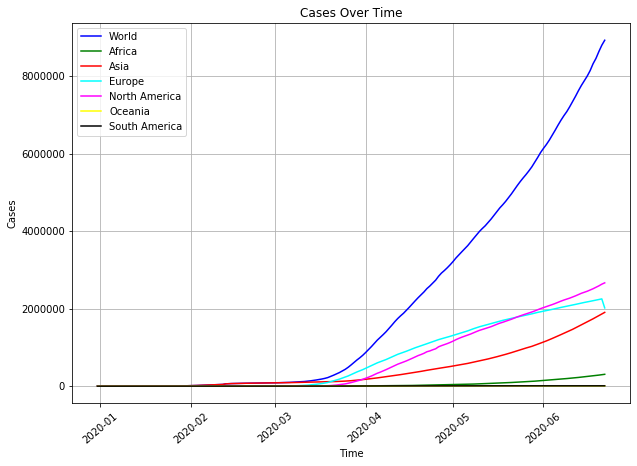

In [56]:
plt.figure(figsize=(10,7))
world_handle, = plt.plot(dates_values, world_cases,color="blue",label="World")
africa_handle, = plt.plot(dates_values, africa_cases_list,color="green",label="Africa")
asia_handle, = plt.plot(dates_values, asia_cases_list,color="red",label="Asia")
europe_handle, = plt.plot(dates_values, europe_cases_list,color="cyan",label="Europe")
north_america_handle, = plt.plot(dates_values, north_america_cases_list,color="magenta",label="North America")
oceania_handle, = plt.plot(dates_values, oceania_cases_list,color="yellow",label="Oceania")
south_america_handle, = plt.plot(dates_values, south_america_cases_list,color="black",label="South America")

plt.xticks(rotation='40')
plt.legend(loc="upper left")
plt.title("Cases Over Time")

plt.xlabel("Time")
plt.ylabel("Cases")

plt.grid()
plt.show()


In [59]:
countires_data = combined_df[combined_df['Date']=='2020-06-22']
countires_data

,Continent,Country,Date,Total Cases,New Cases,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,Hospital Beds (per 10K people),Smoking Percetage,School Status,Latitude,Longitude,Income Level
164,Asia,Afghanistan,2020-06-22,28833.0,409.0,14.925,NaN,NaN,54.422,2.581,1803.987,597.029,5.0,NaN,Closed,34.0230,65.5267,Low income
270,Europe,Albania,2020-06-22,1927.0,36.0,15.289,NaN,NaN,104.871,13.188,11803.431,304.195,29.0,11.20,Open with limitations,40.6540,20.0760,Upper middle income
440,Africa,Algeria,2020-06-22,11771.0,140.0,19.270,NaN,NaN,17.348,6.211,13913.839,278.364,19.0,15.20,Closed,28.6045,2.6400,Upper middle income
541,Europe,Andorra,2020-06-22,855.0,0.0,673.008,NaN,NaN,163.755,NaN,NaN,109.135,NaN,21.40,NaN,NaN,NaN,NaN
634,Africa,Angola,2020-06-22,176.0,4.0,0.274,NaN,NaN,23.890,2.405,5819.495,276.045,8.0,NaN,Closed,-12.8360,17.8080,Lower middle income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,Africa,Western Sahara,2020-06-22,25.0,0.0,1.674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25067,Asia,Yemen,2020-06-22,941.0,18.0,8.583,NaN,NaN,53.508,2.922,1479.147,495.003,7.0,NaN,NaN,NaN,NaN,NaN
25163,Africa,Zambia,2020-06-22,1430.0,0.0,0.598,NaN,NaN,22.995,2.480,3689.251,234.499,20.0,NaN,Closed,-15.1300,25.2680,Lower middle income
25257,Africa,Zimbabwe,2020-06-22,489.0,3.0,0.404,NaN,NaN,42.729,2.822,1899.775,307.846,17.0,NaN,Closed,-19.0980,30.0470,Lower middle income
